# Mixed States Reconstruction (Infidelity as loss)

In [96]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [57]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [58]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [59]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [60]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [85]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.uniform(0,1) * bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [62]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [63]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [124]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

## Noise Model

In [65]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [66]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [67]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [68]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [69]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

## Testing the Algorithm

In [87]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)
#COMPUTE NOISE FREE DENSITY MATRIX
pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]

#COMPUTE BLOCH VECTOR NOISE FREE
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

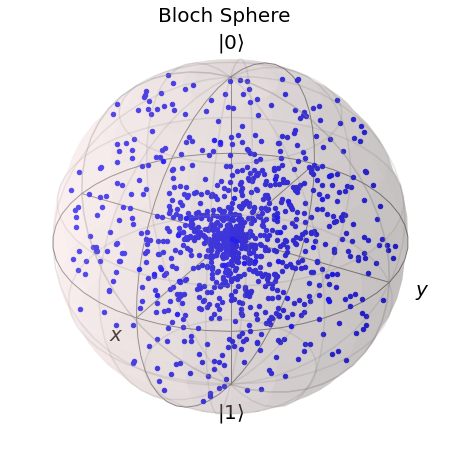

In [88]:
#VISUALIZE DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_noise_free)

In [89]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [90]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

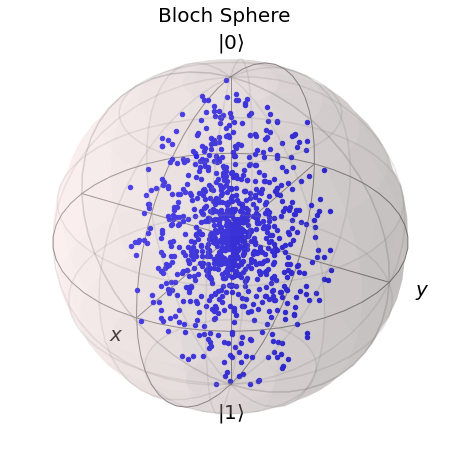

In [91]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_with_noise)

In [92]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:800], bloch_vectors_with_noise[800:900], bloch_vectors_with_noise[900:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:800], bloch_vectors_noise_free[800:900], bloch_vectors_noise_free[900:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [95]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [ ]:
#compute noisy norms
noisy_norms = tf.norm(x_train, axis=1)
noisy_norms_val = tf.norm(x_val, axis=1)
noisy

In [97]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a/b
  return output

In [135]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(128, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
x = Dense(units='3', name='vector')(x)
model_1 = Model(inputs = input_layer1, outputs = x)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Dense(4, activation='relu')(combined)
z = Lambda(custom_layer)(z)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 dense_38 (Dense)               (None, 128)          512         ['input_33[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 64)           8256        ['dense_38[0][0]']               
                                                                                                  
 vector (Dense)                 (None, 3)            195         ['dense_39[0][0]']               
                                                                                           

In [136]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.00005)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=80, epochs=400)

Epoch 1/400
10/10 [==============================] - 1s 28ms/step - loss: 0.3368 - val_loss: 0.3399
Epoch 2/400
10/10 [==============================] - 0s 7ms/step - loss: 0.3341 - val_loss: 0.3287
Epoch 3/400
10/10 [==============================] - 0s 7ms/step - loss: 0.3193 - val_loss: 0.3207
Epoch 4/400
10/10 [==============================] - 0s 8ms/step - loss: 0.3131 - val_loss: 0.3148
Epoch 5/400
10/10 [==============================] - 0s 8ms/step - loss: 0.3099 - val_loss: 0.3107
Epoch 6/400
10/10 [==============================] - 0s 7ms/step - loss: 0.3092 - val_loss: 0.3081
Epoch 7/400
10/10 [==============================] - 0s 8ms/step - loss: 0.3077 - val_loss: 0.3063
Epoch 8/400
10/10 [==============================] - 0s 8ms/step - loss: 0.3072 - val_loss: 0.3041
Epoch 9/400
10/10 [==============================] - 0s 8ms/step - loss: 0.3081 - val_loss: 0.3027
Epoch 10/400
10/10 [==============================] - 0s 8ms/step - loss: 0.3081 - val_loss: 0.3038
Epoch 11

10/10 [==============================] - 0s 8ms/step - loss: 0.4013 - val_loss: 0.3774
Epoch 84/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4035 - val_loss: 0.3771
Epoch 85/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4037 - val_loss: 0.3803
Epoch 86/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4045 - val_loss: 0.3803
Epoch 87/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4068 - val_loss: 0.3839
Epoch 88/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4079 - val_loss: 0.3835
Epoch 89/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4080 - val_loss: 0.3843
Epoch 90/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4081 - val_loss: 0.3837
Epoch 91/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4085 - val_loss: 0.3855
Epoch 92/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4103 - val_loss: 0.3853
Epoch 93/400


10/10 [==============================] - 0s 8ms/step - loss: 0.4479 - val_loss: 0.4279
Epoch 165/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4488 - val_loss: 0.4309
Epoch 166/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4509 - val_loss: 0.4316
Epoch 167/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4504 - val_loss: 0.4291
Epoch 168/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4490 - val_loss: 0.4298
Epoch 169/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4507 - val_loss: 0.4314
Epoch 170/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4508 - val_loss: 0.4307
Epoch 171/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4519 - val_loss: 0.4337
Epoch 172/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4534 - val_loss: 0.4343
Epoch 173/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4532 - val_loss: 0.4326
Epoc

10/10 [==============================] - 0s 10ms/step - loss: 0.4761 - val_loss: 0.4577
Epoch 246/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4768 - val_loss: 0.4568
Epoch 247/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4756 - val_loss: 0.4572
Epoch 248/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4753 - val_loss: 0.4555
Epoch 249/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4746 - val_loss: 0.4573
Epoch 250/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4781 - val_loss: 0.4597
Epoch 251/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4771 - val_loss: 0.4574
Epoch 252/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4765 - val_loss: 0.4582
Epoch 253/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4781 - val_loss: 0.4579
Epoch 254/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4769 - val_loss: 0.4570
Epo

10/10 [==============================] - 0s 8ms/step - loss: 0.4860 - val_loss: 0.4635
Epoch 327/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4861 - val_loss: 0.4643
Epoch 328/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4856 - val_loss: 0.4633
Epoch 329/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4862 - val_loss: 0.4629
Epoch 330/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4855 - val_loss: 0.4635
Epoch 331/400
10/10 [==============================] - 0s 8ms/step - loss: 0.4857 - val_loss: 0.4645
Epoch 332/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4874 - val_loss: 0.4649
Epoch 333/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4866 - val_loss: 0.4628
Epoch 334/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4861 - val_loss: 0.4634
Epoch 335/400
10/10 [==============================] - 0s 7ms/step - loss: 0.4861 - val_loss: 0.4627
Epoc

In [127]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

4/4 - 0s - loss: 4.7450 - 39ms/epoch - 10ms/step


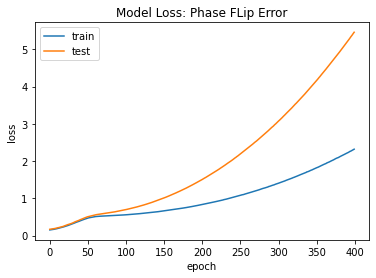

In [128]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()